In [18]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [19]:
data = []
labels = []
paths = []
file_name = []

for sub_folder in os.listdir("/content/dadata"):
    sub_folder_path = os.path.join("/content/dadata", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)
    for i, filename in enumerate(sub_folder_files):
        # Skip hidden files or system files
        if filename.startswith('.') or filename.startswith('_'):
            continue

        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        # Check if the image was successfully loaded
        if img is not None:
            img = img.astype(np.uint8)
            data.append(img)
            labels.append(sub_folder)
            paths.append(img_path)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)
        else:
            print(f"Warning: Unable to read image at path: {img_path}")

data = np.array(data)
labels = np.array(labels)
paths = np.array(paths)

print(len(data), len(labels), len(paths))

800 800 800


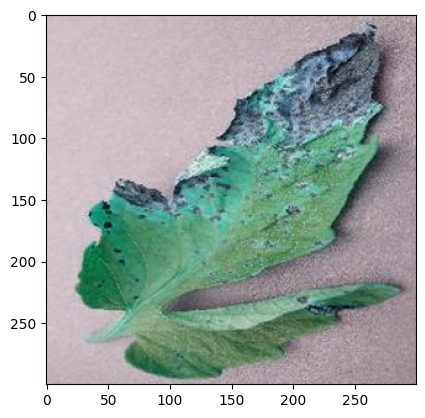

In [20]:
plt.imshow(data[123], cmap='gray')

In [21]:
def convert_to_grayscale(img):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray_img

In [22]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

for i in range(len(data)):
    # Original image
    data_augmented.append(convert_to_grayscale(data[i]))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 90 degrees rotation
    rotated_90 = cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE)
    data_augmented.append(convert_to_grayscale(rotated_90))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 180 degrees rotation
    rotated_180 = cv.rotate(data[i], cv.ROTATE_180)
    data_augmented.append(convert_to_grayscale(rotated_180))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 270 degrees rotation
    rotated_270 = cv.rotate(data[i], cv.ROTATE_90_COUNTERCLOCKWISE)
    data_augmented.append(convert_to_grayscale(rotated_270))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  800
Data setelah augmentasi:  3200


In [23]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [24]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [25]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [26]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [27]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    C45 = correlation(Derajat45[i])
    C90 = correlation(Derajat90[i])
    C135 = correlation(Derajat135[i])
    correlation0.append(C0)

    correlation45.append(C45)

    correlation90.append(C90)

    correlation135.append(C135)

In [28]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [29]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [30]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [31]:
for i in range(len(data)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [32]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [33]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [34]:
# Memeriksa panjang setiap array
print("Filename length:", len(file_name))
print("Label length:", len(labels))
print("Contrast0 length:", len(Kontras0))
print("Contrast45 length:", len(Kontras45))
print("Contrast90 length:", len(Kontras90))
print("Contrast135 length:", len(Kontras135))
print("Homogeneity0 length:", len(homogenity0))
print("Homogeneity45 length:", len(homogenity45))
print("Homogeneity90 length:", len(homogenity90))
print("Homogeneity135 length:", len(homogenity135))
print("Dissimilarity0 length:", len(dissimilarity0))
print("Dissimilarity45 length:", len(dissimilarity45))
print("Dissimilarity90 length:", len(dissimilarity90))
print("Dissimilarity135 length:", len(dissimilarity135))
print("Entropy0 length:", len(entropy0))
print("Entropy45 length:", len(entropy45))
print("Entropy90 length:", len(entropy90))
print("Entropy135 length:", len(entropy135))
print("ASM0 length:", len(ASM0))
print("ASM45 length:", len(ASM45))
print("ASM90 length:", len(ASM90))
print("ASM135 length:", len(ASM135))
print("Energy0 length:", len(energy0))
print("Energy45 length:", len(energy45))
print("Energy90 length:", len(energy90))
print("Energy135 length:", len(energy135))
print("Correlation0 length:", len(correlation0))
print("Correlation45 length:", len(correlation45))
print("Correlation90 length:", len(correlation90))
print("Correlation135 length:", len(correlation135))


Filename length: 800
Label length: 800
Contrast0 length: 800
Contrast45 length: 800
Contrast90 length: 800
Contrast135 length: 800
Homogeneity0 length: 800
Homogeneity45 length: 800
Homogeneity90 length: 800
Homogeneity135 length: 800
Dissimilarity0 length: 800
Dissimilarity45 length: 800
Dissimilarity90 length: 800
Dissimilarity135 length: 800
Entropy0 length: 800
Entropy45 length: 800
Entropy90 length: 800
Entropy135 length: 800
ASM0 length: 800
ASM45 length: 800
ASM90 length: 800
ASM135 length: 800
Energy0 length: 800
Energy45 length: 800
Energy90 length: 800
Energy135 length: 800
Correlation0 length: 800
Correlation45 length: 800
Correlation90 length: 800
Correlation135 length: 800


In [35]:
dataTable = {
    'Filename': file_name,
    'Label': labels,
    'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
    'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
    'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
    'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
    'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
    'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
    'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
}

In [36]:
df = pd.DataFrame(dataTable)
df.to_csv('hasil_0.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_0.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Tomato___Septoria_leaf_spot_199.jpg,tomato_septoria_leaf_spot,429.787012,682.466706,535.715998,669.538931,0.127471,0.091466,0.102479,0.089099,...,0.000210,0.000186,0.016091,0.013814,0.014495,0.013645,0.851655,0.764174,0.814850,0.768653
1,Tomato___Septoria_leaf_spot_34.jpg,tomato_septoria_leaf_spot,535.715998,669.538931,429.787012,682.466706,0.102479,0.089099,0.127471,0.091466,...,0.000259,0.000191,0.014495,0.013645,0.016091,0.013814,0.814850,0.768653,0.851655,0.764174
2,Tomato___Septoria_leaf_spot_189.jpg,tomato_septoria_leaf_spot,429.787012,682.466706,535.715998,669.538931,0.127471,0.091466,0.102479,0.089099,...,0.000210,0.000186,0.016091,0.013814,0.014495,0.013645,0.851655,0.764174,0.814850,0.768653
3,Tomato___Septoria_leaf_spot_36.jpg,tomato_septoria_leaf_spot,535.715998,669.538931,429.787012,682.466706,0.102479,0.089099,0.127471,0.091466,...,0.000259,0.000191,0.014495,0.013645,0.016091,0.013814,0.814850,0.768653,0.851655,0.764174
4,Tomato___Septoria_leaf_spot_178.jpg,tomato_septoria_leaf_spot,164.013423,258.224203,152.313311,218.842295,0.232094,0.180714,0.214139,0.186508,...,0.001029,0.000886,0.033450,0.029317,0.032080,0.029764,0.962713,0.941430,0.965354,0.950363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Tomato___Bacterial_spot_32.jpg,tomato_bacterical_spot,289.656176,402.539871,268.591940,404.789275,0.106566,0.090790,0.110391,0.089048,...,0.000221,0.000187,0.014688,0.013770,0.014855,0.013687,0.938293,0.914329,0.942768,0.913850
796,Tomato___Bacterial_spot_29.jpg,tomato_bacterical_spot,458.914916,629.977282,464.707648,647.069496,0.084629,0.069720,0.082915,0.069846,...,0.000194,0.000171,0.014010,0.013064,0.013913,0.013087,0.897337,0.859373,0.896082,0.855558
797,Tomato___Bacterial_spot_36.jpg,tomato_bacterical_spot,464.707648,647.069496,458.914916,629.977282,0.082915,0.069846,0.084629,0.069720,...,0.000196,0.000171,0.013913,0.013087,0.014010,0.013064,0.896082,0.855558,0.897337,0.859373
798,Tomato___Bacterial_spot_8.jpg,tomato_bacterical_spot,458.914916,629.977282,464.707648,647.069496,0.084629,0.069720,0.082915,0.069846,...,0.000194,0.000171,0.014010,0.013064,0.013913,0.013087,0.897337,0.859373,0.896082,0.855558


<Axes: >

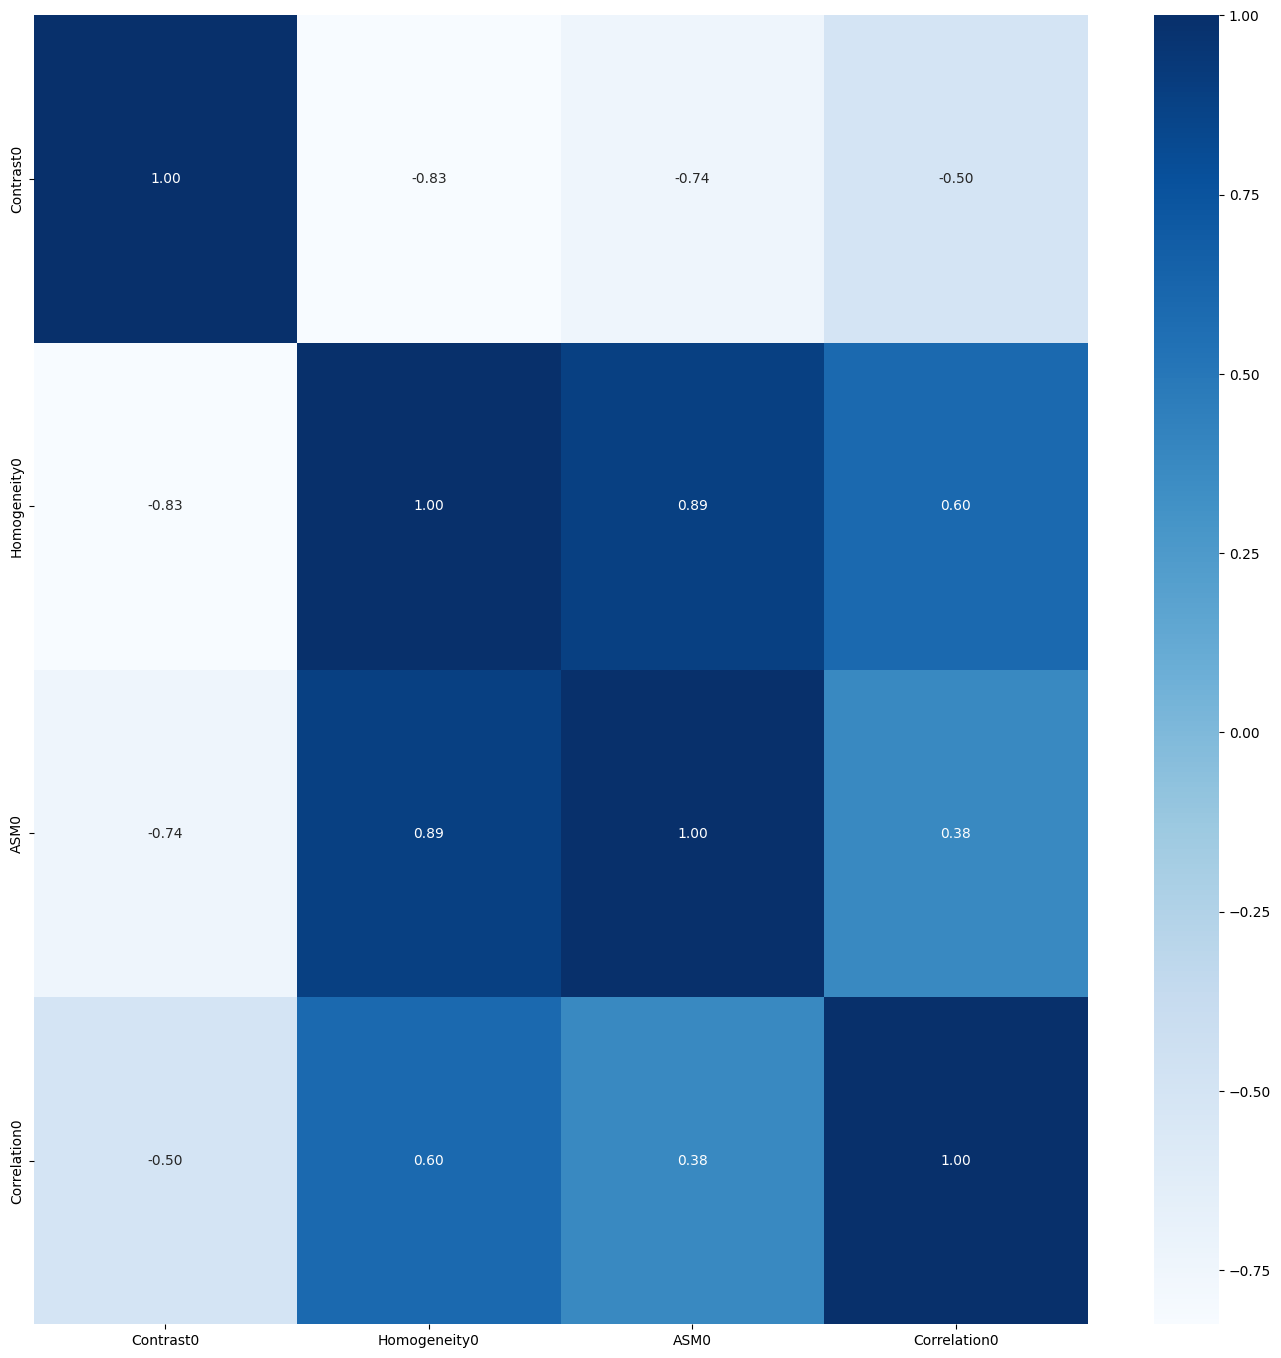

In [37]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

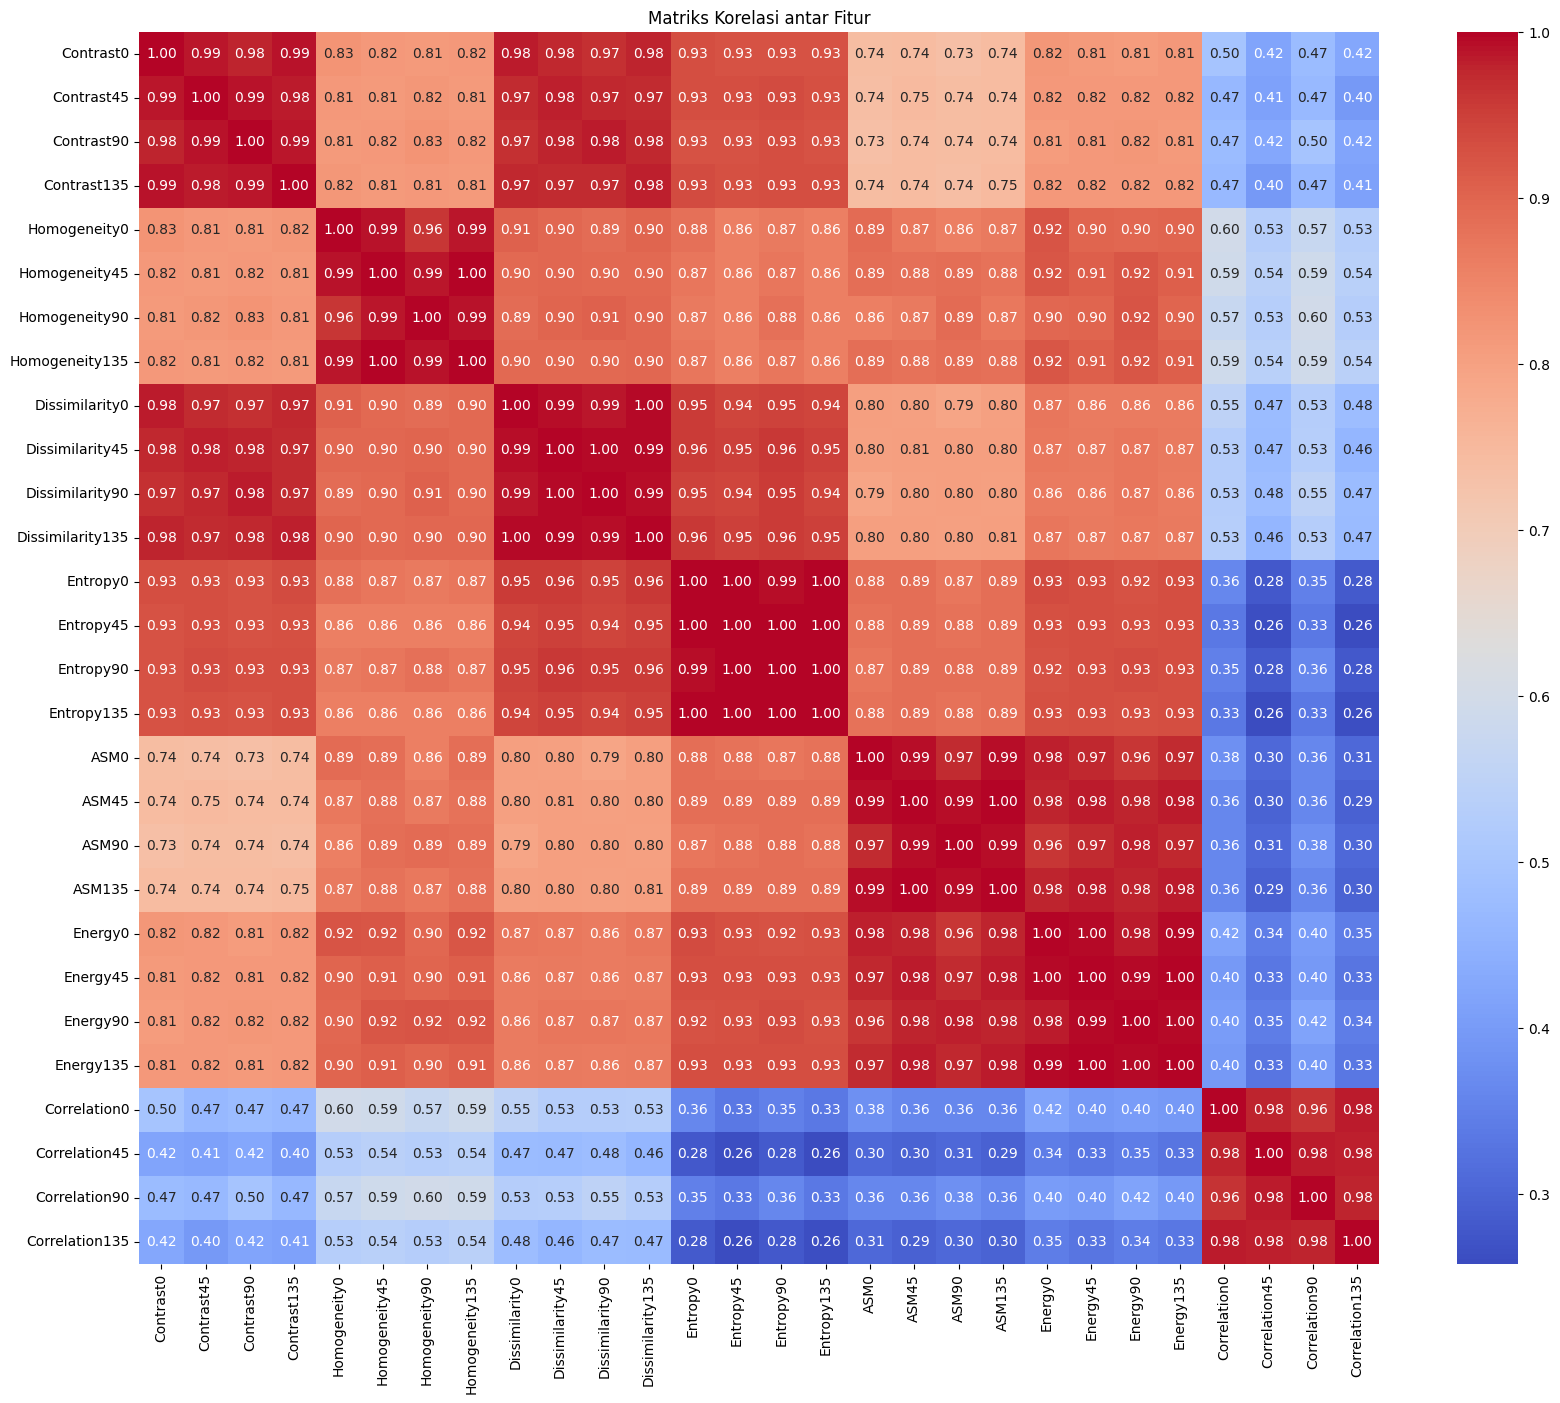

In [38]:
numeric_cols = hasilEkstrak.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi antar Fitur')
plt.show()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

      Contrast0  Homogeneity0      ASM0  Correlation0
404  452.511037      0.090018  0.000145      0.891803
522  189.468584      0.136955  0.000466      0.954283
749  543.211561      0.084774  0.000109      0.894437
426  184.709810      0.106412  0.000345      0.805094
41   325.713423      0.081367  0.000205      0.786620
..          ...           ...       ...           ...
71   463.702319      0.133546  0.000686      0.898021
106  560.806265      0.069593  0.000112      0.885917
270  270.459978      0.108552  0.000321      0.833287
435  128.384526      0.145650  0.000393      0.916917
102   64.089175      0.250361  0.001328      0.944708

[560 rows x 4 columns]
      Contrast0  Homogeneity0      ASM0  Correlation0
696   95.253902      0.278651  0.001043      0.974365
667   45.013857      0.303479  0.000872      0.976220
63    92.975139      0.179069  0.000793      0.848505
533  155.577068      0.167646  0.000506      0.897618
66    91.896644      0.210845  0.000994      0.915694
..  

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [42]:
report_rf = classification_report(y_test, y_pred_rf)
print("Report Random Forest")
print(report_rf)

Report Random Forest
                           precision    recall  f1-score   support

   tomato_bacterical_spot       0.79      0.84      0.82        64
      tomato_early_blight       0.89      0.75      0.81        63
           tomato_healthy       0.80      0.76      0.78        51
tomato_septoria_leaf_spot       0.83      0.94      0.88        62

                 accuracy                           0.82       240
                macro avg       0.83      0.82      0.82       240
             weighted avg       0.83      0.82      0.82       240



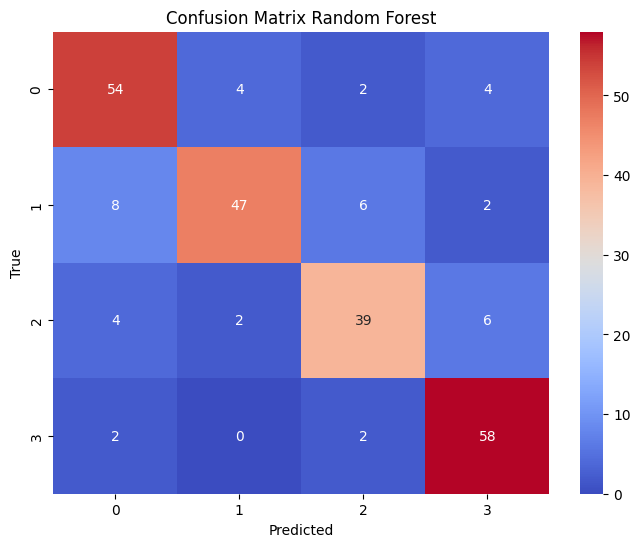

In [43]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='coolwarm')

plt.title('Confusion Matrix Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [44]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1

In [45]:
print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=50))



Random Forest
Accuracy: 42.00%
Precision: 41.98%
Recall: 42.00%
F1 Score: 41.97%
